### 1. Import Libraries & Load data

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from datetime import datetime

sns.set_theme(style='whitegrid')

# Load the data
df_day = pd.read_csv('../cleanData/merged_by_day.csv', parse_dates=['Date'])
df_carrier = pd.read_csv('../cleanData/merged_by_day_carrier.csv', parse_dates=['Date'])

### 2. Volume Comparison

#### 2-0 Total Package Volume

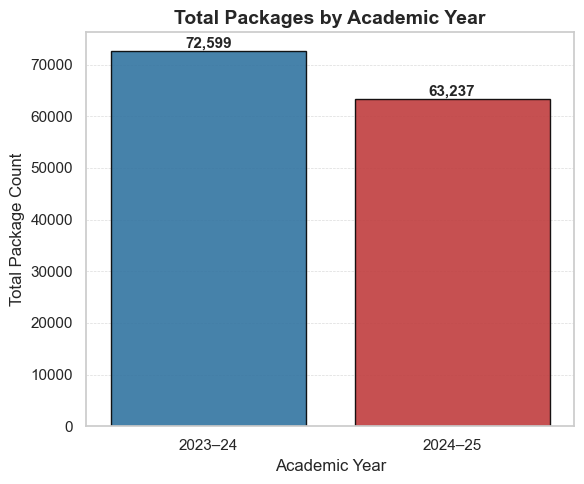

In [20]:
# Calculate total packages per academic year
total_2324 = df_day['count_2324'].sum()
total_2425 = df_day['count_2425'].sum()

# Create dataframe for plotting
totals_df = pd.DataFrame({
    'Academic Year': ['2023–24', '2024–25'],
    'Total Packages': [total_2324, total_2425]
})

# Safer and cleaner version
plt.figure(figsize=(6, 5))
sns.barplot(data=totals_df, x='Academic Year', y='Total Packages',
            hue='Academic Year', palette=['tab:blue', 'tab:red'], 
            edgecolor='black', alpha=0.9, legend=False)

for i, row in totals_df.iterrows():
    plt.text(i, row['Total Packages'] + 100, f"{int(row['Total Packages']):,}", 
             ha='center', va='bottom', fontweight='bold', fontsize=11)

plt.title('Total Packages by Academic Year', fontsize=14, fontweight='bold')  # removed 📦
plt.ylabel('Total Package Count', fontsize=12)
plt.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()


#### 2-1. Monthly Volume Comparison

#### 2-1 a | Preprocess Academic Year in Months

In [21]:
# Step 1: Rename + create helper columns
df_day = df_day.rename(columns={
    'Date': 'date',
    'count_2324': '2023~24',
    'count_2425': '2024~25'
})

# Step 2: Create 'month' column (short month name: Aug, Sep, etc.)
df_day['month'] = df_day['date'].dt.strftime('%b')
df_day['month_num'] = df_day['date'].dt.month # for sorting

# Step 3: Melt to long format
df_long = df_day.melt(id_vars=['date', 'month', 'month_num'], 
                      value_vars=['2023~24', '2024~25'], 
                      var_name='year', value_name='count')

# Step 4: Remove 0s (non-applicable months)
df_long = df_long[df_long['count'] > 0]

# Step 5: Group by month name + year
monthly_grouped = df_long.groupby(['month', 'month_num', 'year'])['count'].sum().reset_index()

# Step 6: Sort by month_num (Jul = 7, ..., June = 6, so wrap logic)
month_order = [7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6]
monthly_grouped['month'] = pd.Categorical(
    monthly_grouped['month'],
    categories=[datetime(2000, m, 1).strftime('%b') for m in month_order],
    ordered=True
)
monthly_grouped = monthly_grouped.sort_values('month')

# Step 7: Calculate percentage of each month
monthly_grouped['percent'] = monthly_grouped.groupby('year')['count'].transform(lambda x: 100 * x / x.sum())

#### 2-1 b | Plot Monthly Volume

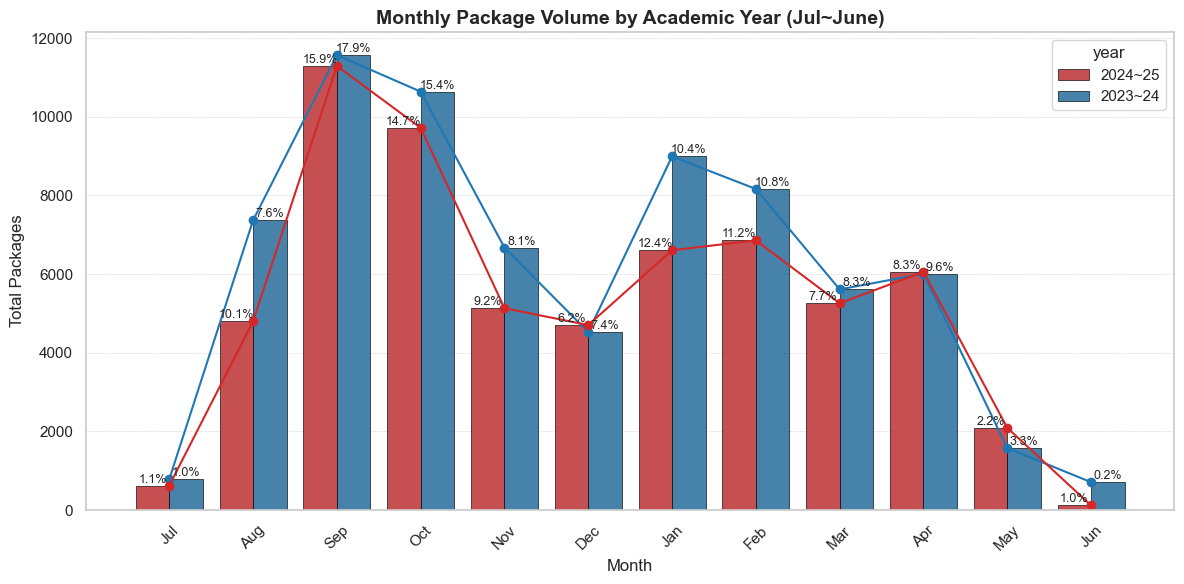

In [22]:
# Step 8: Plot
plt.figure(figsize=(12, 6))
barplot = sns.barplot(data=monthly_grouped, x='month', y='count', hue='year', 
                      palette={'2023~24': 'tab:blue', '2024~25': 'tab:red'}, 
                      alpha=0.9, edgecolor='black', linewidth=0.5)

# Add percentage labels on top of bars
for bars, (_, subdf) in zip(barplot.containers, monthly_grouped.groupby('year')):
    labels = [f'{p:.1f}%' for p in subdf['percent']]
    barplot.bar_label(bars, labels=labels, label_type='edge', fontsize=9)

# Line overlay
for year, group in monthly_grouped.groupby('year'):
    plt.plot(group['month'], group['count'], marker='o', 
             color='tab:blue' if year == '2023~24' else 'tab:red')

plt.title('Monthly Package Volume by Academic Year (Jul~June)', fontsize=14, fontweight='bold')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Total Packages', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

#### 2-2. Weekly Volume Comparison

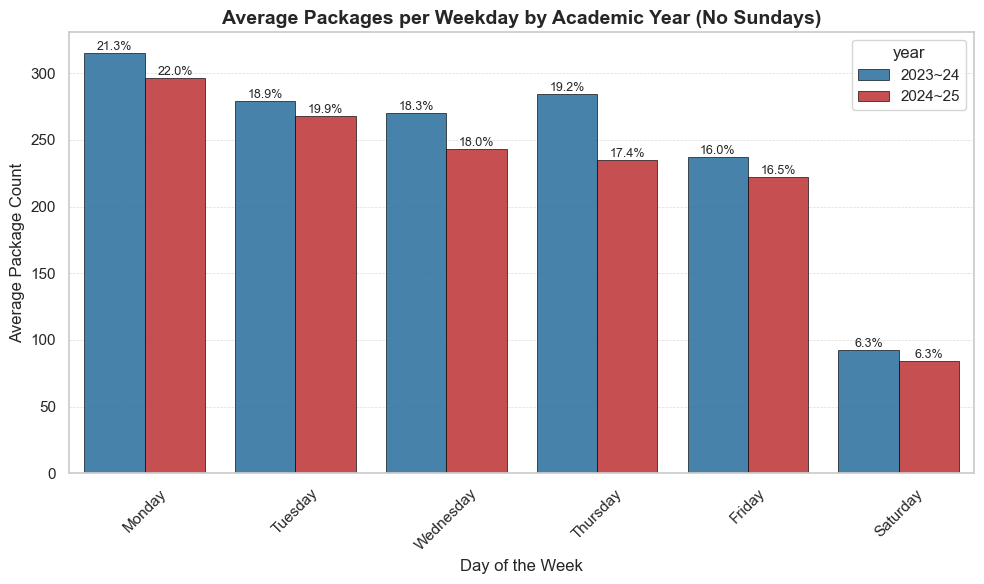

In [23]:
# Step 1: Prep the data
weekday_df = df_day.copy()
weekday_df['weekday'] = weekday_df['date'].dt.day_name()

# Remove Sundays completely
weekday_df = weekday_df[weekday_df['weekday'] != 'Sunday']

# Melt into long format
weekday_long = weekday_df.melt(
    id_vars=['date', 'weekday'], 
    value_vars=['2023~24', '2024~25'],
    var_name='year',
    value_name='count'
)

# Filter out 0s (i.e. when the year doesn’t apply)
weekday_long = weekday_long[weekday_long['count'] > 0]

# Step 2: Group by weekday + year
weekday_avg = weekday_long.groupby(['weekday', 'year'])['count'].mean().reset_index()

# Order the weekdays properly
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
weekday_avg['weekday'] = pd.Categorical(weekday_avg['weekday'], categories=weekday_order, ordered=True)
weekday_avg = weekday_avg.sort_values('weekday')

# Calculate the percentage of each weekday
weekday_avg['percent'] = weekday_avg.groupby('year')['count'].transform(lambda x: 100 * x / x.sum())

# Step 3: Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=weekday_avg, x='weekday', y='count', hue='year',
            palette={'2023~24': 'tab:blue', '2024~25': 'tab:red'},
            alpha=0.9, edgecolor='black', linewidth=0.5)

# Add percentage labels to each bar
for bars, (_, subdf) in zip(plt.gca().containers, weekday_avg.groupby('year')):
    labels = [f'{p:.1f}%' for p in subdf['percent']]
    plt.bar_label(bars, labels=labels, label_type='edge', fontsize=9)


plt.title('Average Packages per Weekday by Academic Year (No Sundays)', fontsize=14, fontweight='bold')
plt.xlabel('Day of the Week', fontsize=12)
plt.ylabel('Average Package Count', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()


### 3. Carrier Breakdown

#### 3-1. Number of Packages by Carrier

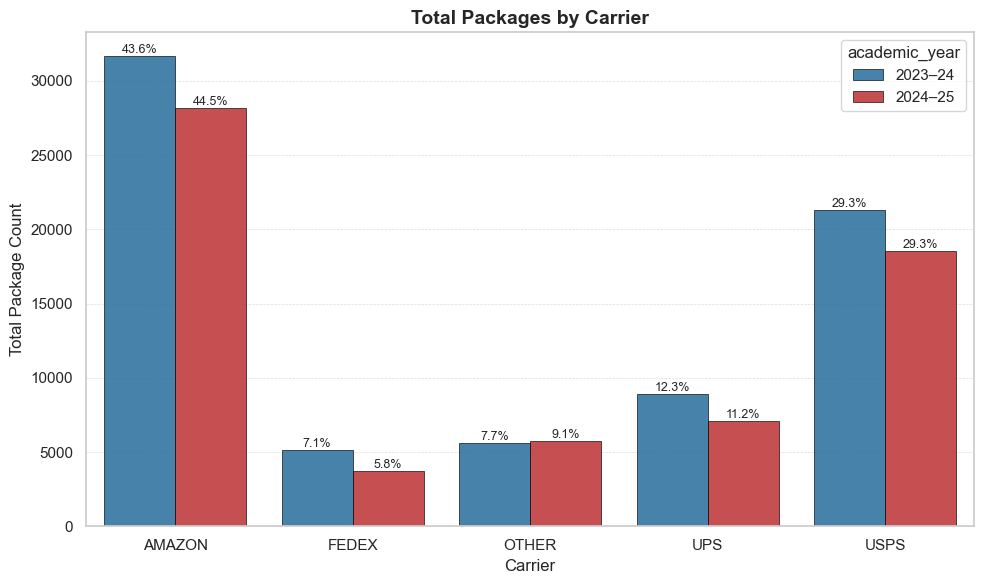

In [24]:
# Load carrier daily data
carrier_df = df_carrier.copy()

# Extract academic year
def get_academic_year(date):
    if pd.Timestamp('2023-07-01') <= date <= pd.Timestamp('2024-06-30'):
        return '2023–24'
    elif pd.Timestamp('2024-07-01') <= date <= pd.Timestamp('2025-06-30'):
        return '2024–25'
    else:
        return None

carrier_df['academic_year'] = carrier_df['Date'].apply(get_academic_year)
carrier_df = carrier_df[carrier_df['academic_year'].notnull()]

# Melt to long format (USPS, UPS, FEDEX, AMAZON, OTHER)
carrier_long = carrier_df.melt(
    id_vars=['Date', 'academic_year'],
    value_vars=['USPS', 'UPS', 'FEDEX', 'AMAZON', 'OTHER'],
    var_name='carrier',
    value_name='count'
)

# Group and sum by carrier and academic year
carrier_summary = carrier_long.groupby(['carrier', 'academic_year'])['count'].sum().reset_index()

# Calculate percentage of each carrier within each academic year
carrier_summary['percent'] = carrier_summary.groupby('academic_year')['count'].transform(lambda x: 100 * x / x.sum())

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=carrier_summary, x='carrier', y='count', hue='academic_year',
            palette={'2023–24': 'tab:blue', '2024–25': 'tab:red'}, 
            alpha=0.9, edgecolor='black', linewidth=0.5)

# Add percentage labels to each bar
for bars, (_, subdf) in zip(plt.gca().containers, carrier_summary.groupby('academic_year')):
    labels = [f'{p:.1f}%' for p in subdf['percent']]
    plt.bar_label(bars, labels=labels, label_type='edge', fontsize=9)

plt.title('Total Packages by Carrier', fontsize=14, fontweight='bold')
plt.xlabel('Carrier', fontsize=12)
plt.ylabel('Total Package Count', fontsize=12)
plt.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()


#### 3-2. Daily Package Volume by Carrier

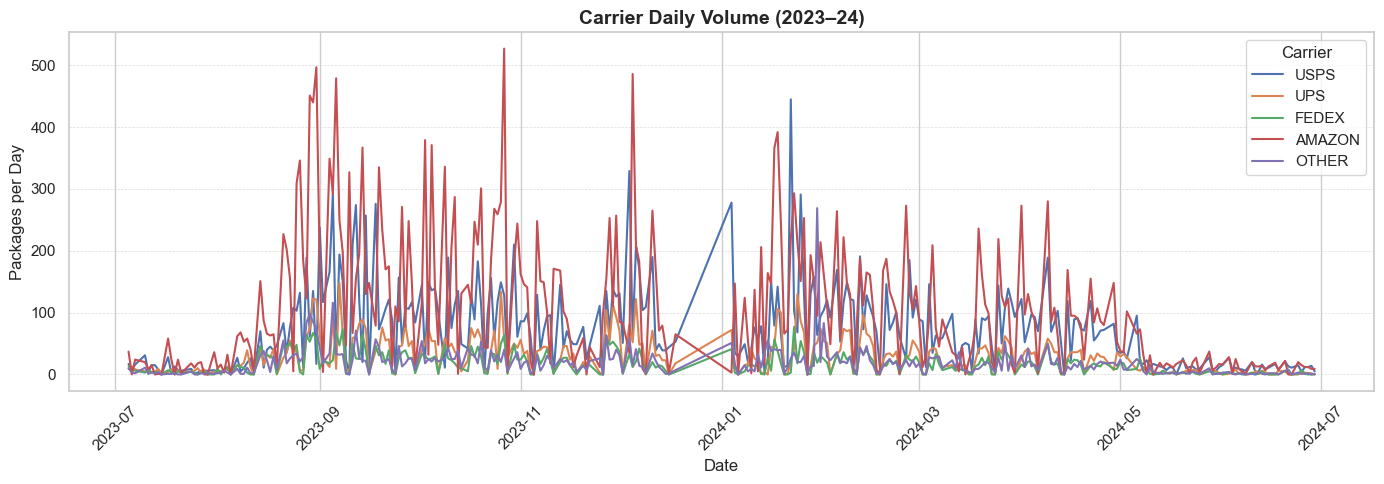

In [25]:
# Plot 2023–24 daily trend
plt.figure(figsize=(14, 5))
sns.lineplot(
    data=carrier_long[carrier_long['academic_year'] == '2023–24'],
    x='Date',
    y='count',
    hue='carrier'
)
plt.title('Carrier Daily Volume (2023–24)', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Packages per Day', fontsize=12)
plt.legend(title='Carrier')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()


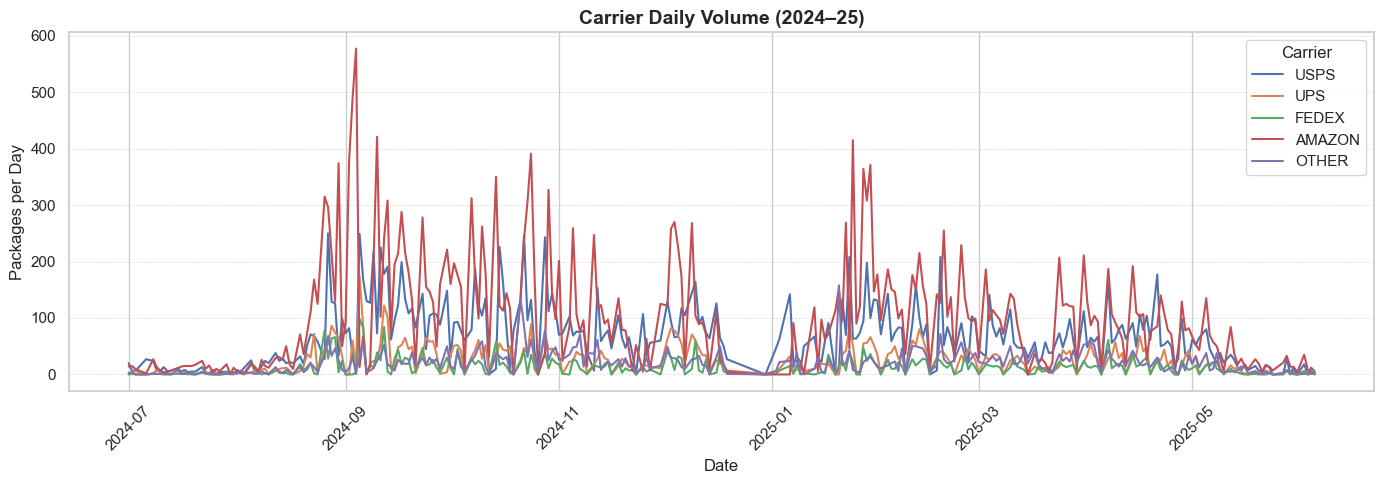

In [26]:
# Plot 2024–25 daily trend
plt.figure(figsize=(14, 5))
sns.lineplot(
    data=carrier_long[carrier_long['academic_year'] == '2024–25'],
    x='Date',
    y='count',
    hue='carrier'
)
plt.title('Carrier Daily Volume (2024–25)', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Packages per Day', fontsize=12)
plt.legend(title='Carrier')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()
